In [1]:
# Importing libaries
import numpy as np
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# #Importing splitting techniques
from sklearn.model_selection import KFold

# Importing sampling techniques
from sklearn.utils import resample
from collections import Counter

# Importing ML libraries for classification
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, PrecisionRecallDisplay, auc


In [2]:
# Load card_transactions dataset
df = pd.read_csv('data/creditcard.csv')

# View first 5 rows of dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows before drop: {num_duplicates}")

# Drop duplicate rows
df = df.drop_duplicates()

num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows after drop: {num_duplicates}")

Number of duplicate rows before drop: 1081
Number of duplicate rows after drop: 0


Class distribution before oversampling:
Counter({0: 283253, 1: 473})


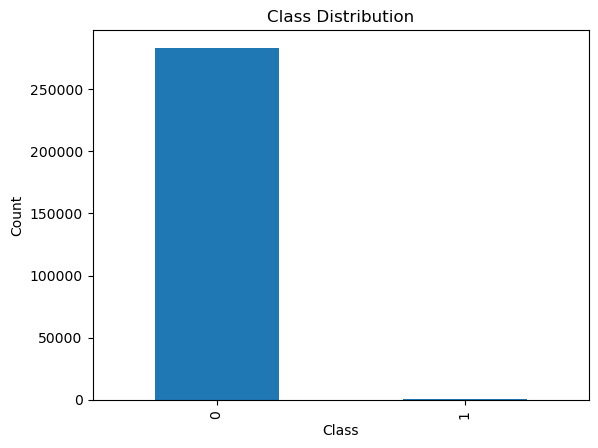

In [4]:
# Check the class distribution before oversampling
print("Class distribution before oversampling:")
print(Counter(df['Class']))

# Visualise the distribution
df['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# K-Fold Cross-Validation Splitting
#### Split the dataset through k-fold cross-validation

In [5]:
X = df.drop(columns='Class').values
y = df['Class'].values

# K-Fold cross-validator
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    # Split data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Convert training data to dataframe for random oversampling
    train_df = pd.DataFrame(X_train, columns=df.columns[:-1])
    train_df['Class'] = y_train
    
    # Separate minority (fraud) and majority (genuine) classes
    df_majority = train_df[train_df['Class'] == train_df['Class'].value_counts().idxmax()]
    df_minority = train_df[train_df['Class'] != train_df['Class'].value_counts().idxmax()]

    # Random oversampling to the minority (fraud) class
    df_minority_oversample = resample(df_minority,
                                     replace=True, 
                                     n_samples=len(df_majority), #to match majority class
                                     random_state=42)

    # Combine majority class (genuine) with randomly oversampled minority class (fraud)
    train_df_oversample = pd.concat([df_majority, df_minority_oversample])

    # Separate features and target of the oversampled training data
    X_train_oversample = train_df_oversample.drop(columns='Class').values
    y_train_oversample = train_df_oversample['Class'].values

#### Random Forest

Accuracy: 0.999365571690399
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28323
           1       0.88      0.73      0.80        49

    accuracy                           1.00     28372
   macro avg       0.94      0.87      0.90     28372
weighted avg       1.00      1.00      1.00     28372



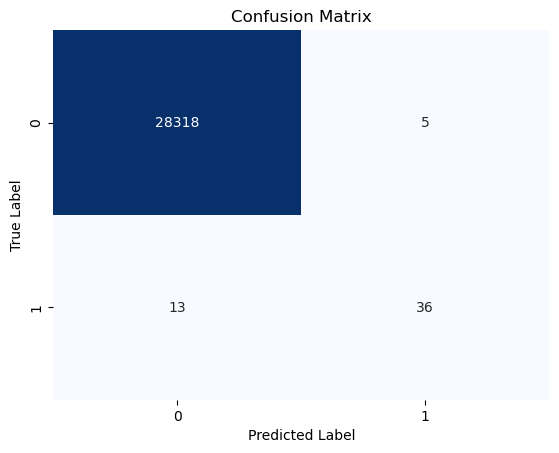

AUPRC: 0.8267689543201563


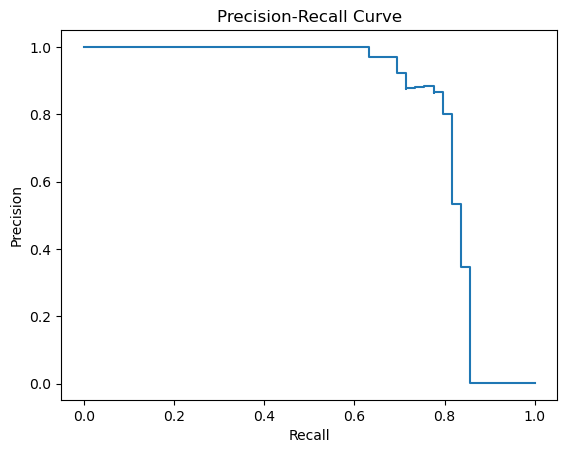

In [6]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=50, random_state=42)

# Fit the model with the training data
rf.fit(X_train_oversample, y_train_oversample)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Precision-Recall curve
y_scores = rf.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

#Calculate AUPRC
auprc = auc(recall, precision)
print("AUPRC:", auprc)

# Plot precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

#### Logistic Regression

Accuracy: 0.9661638234879458
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     28323
           1       0.04      0.90      0.08        49

    accuracy                           0.97     28372
   macro avg       0.52      0.93      0.53     28372
weighted avg       1.00      0.97      0.98     28372



C:\Users\polin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


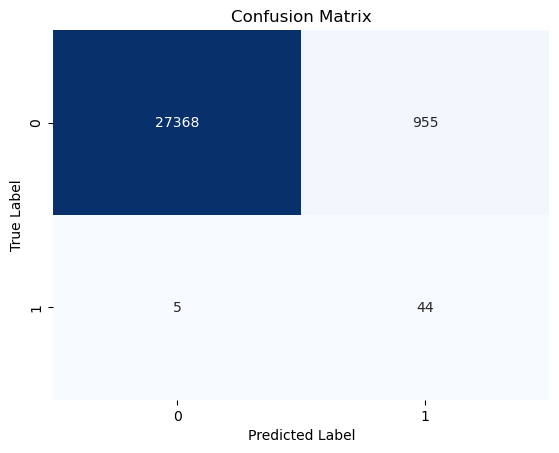

AUPRC: 0.7491883936786964


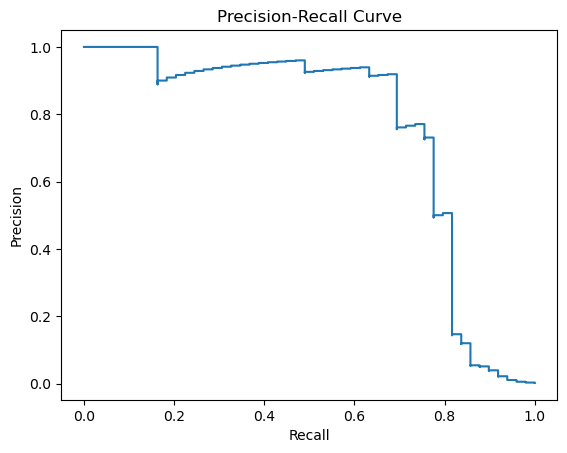

In [7]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42)

# Fit the model with the training data
lr.fit(X_train_oversample, y_train_oversample)

# Predict on the test set
y_pred = lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Precision-Recall curve
y_scores = lr.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

#Calculate AUPRC
auprc = auc(recall, precision)
print("AUPRC:", auprc)

# Plot precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

#### kNN

Accuracy: 0.9973213026927957
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28323
           1       0.21      0.20      0.21        49

    accuracy                           1.00     28372
   macro avg       0.61      0.60      0.60     28372
weighted avg       1.00      1.00      1.00     28372



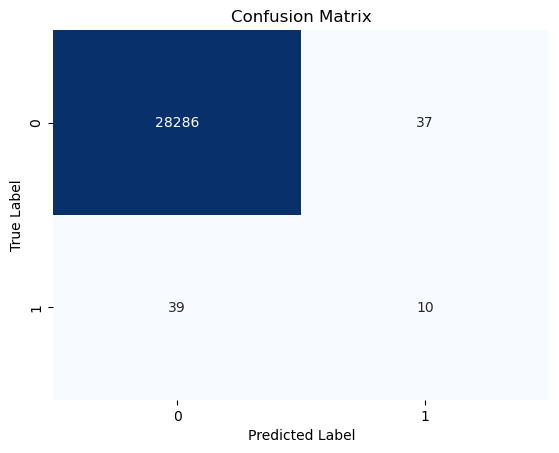

AUPRC: 0.1987766968444989


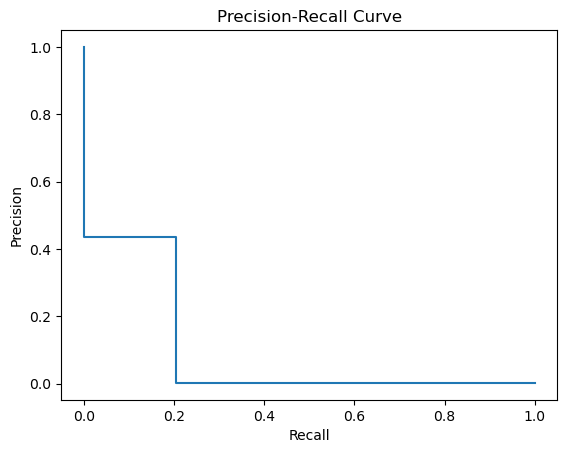

In [8]:
# Initialise the kNN model
knn = KNeighborsClassifier(n_neighbors=5) 

# Fit the model with the training data
knn.fit(X_train_oversample, y_train_oversample)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Precision-Recall curve
y_scores = knn.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

#Calculate AUPRC
auprc = auc(recall, precision)
print("AUPRC:", auprc)

# Plot precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

#### Naive Bayes

Accuracy: 0.9913999718031863
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     28323
           1       0.14      0.78      0.24        49

    accuracy                           0.99     28372
   macro avg       0.57      0.88      0.62     28372
weighted avg       1.00      0.99      0.99     28372



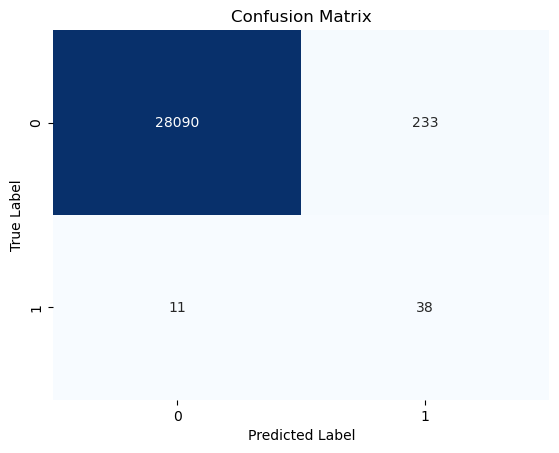

AUPRC: 0.39885880276940455


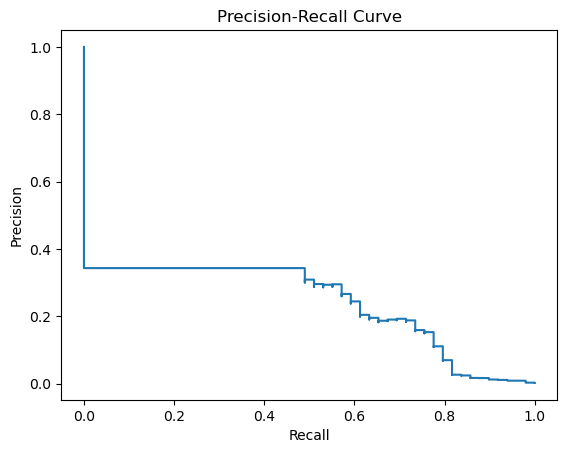

In [9]:
# Initialise the naive bayes model
nb = GaussianNB() 

# Fit the model with the training data
nb.fit(X_train_oversample, y_train_oversample)

# Predict on the test set
y_pred = nb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualise the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Precision-Recall curve
y_scores = nb.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

#Calculate AUPRC
auprc = auc(recall, precision)
print("AUPRC:", auprc)

# Visualise precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()